In [ ]:
import sys
print(sys.executable)


/usr/bin/python3


In [ ]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import joblib

# preprocess & augmentation
import os
import cv2
from google.colab.patches import cv2_imshow

# region proposal -> object detection
from sklearn.svm import LinearSVC
# from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer
# from google.colab.patches import cv2_imshow


In [ ]:
# GPU cek
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [ ]:
print(tf.__version__)

2.19.0


### drive test

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


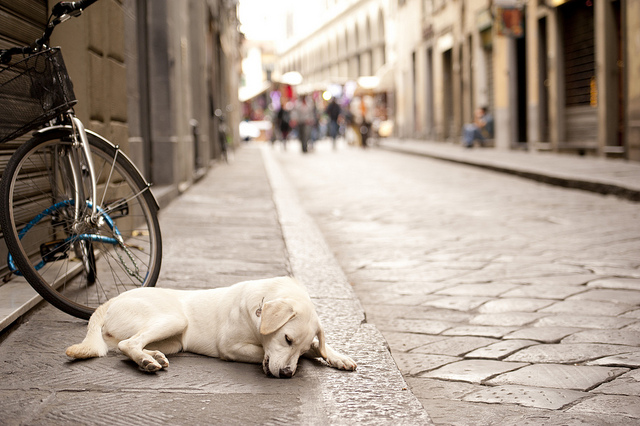

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/KULIAH/SEM-5/caption-generation/dog-example.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(test_img)

# 1. Load COCO2017 - for collab

In [ ]:
from zipfile import ZipFile
import requests
import json

# progress bar
from tqdm import tqdm
import shutil

In [ ]:
# 1. buat directory
base_dir="./data/coco2017"

# struktur folder
os.makedirs(os.path.join(base_dir, "images", "train2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "val2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "annotations"), exist_ok=True)

print("Folder successfully created...")


Folder successfully created...


In [ ]:
urls = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images": "http://images.cocodataset.org/zips/val2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

download_dir = base_dir
subset_size= 50000

# download & extract
for name, url in urls.items():
  # print(name, url)
  zip_path = os.path.join(download_dir, f"{name}.zip")

  print(f"Donwload {name}...")
  response = requests.get(url, stream=True) #donwload bertahap(stream)
  with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
      # pastikan write tdk empty
      if chunk:
        f.write(chunk)
  print(f"Download & extract {zip_path}...")

  with ZipFile(zip_path, 'r') as zip_ref:
    if "train" in name:
      zip_ref.extractall(os.path.join(base_dir, "images", "train2017"))
    elif "val" in name:
      zip_ref.extractall(os.path.join(base_dir, "images", "val2017"))
    else:
      zip_ref.extractall(os.path.join(base_dir, "annotations"))
  print(f"Extracted {name}")

print("process donwload & extract done.")

Donwload train_images...
Download & extract ./data/coco2017/train_images.zip...
Extracted train_images
Donwload val_images...
Download & extract ./data/coco2017/val_images.zip...
Extracted val_images
Donwload annotations...
Download & extract ./data/coco2017/annotations.zip...
Extracted annotations
process donwload & extract done.


In [ ]:
import json
base_dir="./data/coco2017"

annotation_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017.json")
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"

with open(annotation_path, "r") as f:
    data = json.load(f)

print(data.keys())


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [ ]:
# get instances subset (JSON) - take 50ribu (10 rb an image)
annotation_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017.json")
subset_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017_subset.json")
subset_size=50000

if not os.path.exists(annotation_path):
  print(f"Error annot file not found = {annotation_path}")
else:
  with open(annotation_path, "r") as f:
    data=json.load(f)
  print(f"total annot asli : {len(data['annotations'])}")

  print(f"key in json: {data.keys()}")
  # subset
  subset_annot = data['annotations'][:subset_size]
  subset_category = data['categories']

  # ambil id gbr
  img_ids = set(ann["image_id"] for ann in subset_annot)
  subset_img_info = [img for img in data["images"] if img["id"] in img_ids]

  # simpan subset
  subset_data = {
      "info": data.get("info", {}),
      "licenses": data.get("licenses", []),
      "images": subset_img_info, # info image di subset
      "annotations": subset_annot,
      "categories": subset_category
  }

  os.makedirs(os.path.dirname(subset_path), exist_ok=True)
  with open(subset_path, "w") as f:
      json.dump(subset_data, f)

  print(f"Subset JSON dibuat: {subset_path}")
  print(f"tot img di subset info: {len(subset_img_info)} | Tot annotations: {len(subset_annot)}")

  # copy ke local source
  src_dir_option = os.path.join(base_dir, "images", "train2017", "train2017") # Common structure from zip

  src_dir = None
  if os.path.exists(src_dir_option) and len(os.listdir(src_dir_option)) > 0:
      src_dir = src_dir_option


  if src_dir:
      # destination directory
      dst_dir = os.path.join(base_dir, "images", "train2017_subset")
      os.makedirs(dst_dir, exist_ok=True)

      print(f"\nCopying subset image files from {src_dir} to {dst_dir}...")
      # Copy only file names present in the subset_images_info
      copied_count = 0
      # Create a set of file names to copy for faster lookup
      subset_image_filenames = {img_info["file_name"] for img_info in subset_img_info}

      # Iterate through files in the source directory and copy if they are in the subset
      for filename in tqdm(os.listdir(src_dir), desc="Checking & copying images"):
          if filename in subset_image_filenames:
                src_path = os.path.join(src_dir, filename)
                dst_path = os.path.join(dst_dir, filename)
                try:
                    shutil.copy(src_path, dst_path)
                    copied_count += 1
                except Exception as e:
                    print(f"Warning: Could not copy file {src_path} to {dst_path}: {e}")


      print(f"Finished copying. {copied_count} images copied to subset folder.")
      # Check if the number of copied files matches the number of images in the subset info
      if copied_count != len(subset_img_info):
          print(f"Warning: Number of copied files ({copied_count}) != subset info ({len(subset_img_info)}). Some source files might be missing.")

      print("Subset 50K image & annotations (locally copied images) ready")


total annot asli : 860001
key in json: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Subset JSON dibuat: ./data/coco2017/annotations/annotations/instances_train2017_subset.json
tot img di subset info: 7920 | Tot annotations: 50000

Copying subset image files from ./data/coco2017/images/train2017/train2017 to ./data/coco2017/images/train2017_subset...


Checking & copying images: 100%|██████████| 118287/118287 [00:28<00:00, 4130.14it/s]

Finished copying. 7920 images copied to subset folder.
Subset 50K image & annotations (locally copied images) ready


In [ ]:
def load_coco_detection_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f) # images, annotations bonding box, categories label

  # map img id -> filename
  images = {img['id']: img for img in ann['images']}

  # dict
  # pairs=[]
  grouped_pairs={}

  for item in ann['annotations']:
    img_id = item['image_id']
    # img_meta = images[item['image_id']]
    # img_path = os.path.join(img_dir, img_meta['file_name'])
    if img_id not in grouped_pairs:
      img_meta = images[img_id]
      img_path = os.path.join(img_dir, img_meta['file_name'])

      if os.path.exists(img_path):
        grouped_pairs[img_id]={
            "img": img_path,
            "boxes": [], #list boxes
            "labels": [] # list label
        }
      else:
        continue

    grouped_pairs[img_id]['boxes'].append(item['bbox'])
    grouped_pairs[img_id]['labels'].append(item['category_id'])

  pairs = list(grouped_pairs.values())
  return pairs

In [ ]:
import json

path = "./data/coco2017/annotations/annotations/instances_val2017.json"
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"

with open(train_annot_path, "r") as f:
    data_train = json.load(f)

print(data_train.keys())


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [ ]:
# 1. load coco pairs
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"
val_annot_path = "./data/coco2017/annotations/annotations/instances_val2017.json"

train_img_dir = "./data/coco2017/images/train2017_subset"
val_img_dir = "./data/coco2017/images/val2017/val2017"

train_pairs_detection = load_coco_detection_pairs(train_img_dir, train_annot_path)
val_pairs_detection = load_coco_detection_pairs(val_img_dir, val_annot_path)
print(train_pairs_detection[0])
print("Tot TRAIN detection pairs annot: ", len(train_pairs_detection))
print("Tot VAL detection pairs annot: ", len(val_pairs_detection))

# cek kategori ada brp
with open(train_annot_path, 'r') as f:
    ann=json.load(f)
categories = ann.get("categories", [])
print("Total categories: ", len(categories))

print("\n Sample category: ")
for cat in categories[:5]:
  print(f"{cat["id"]} : {cat["name"]}")

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}
Tot TRAIN detection pairs annot:  7920
Tot VAL detection pairs annot:  4952
Total categories:  80

 Sample category: 
1 : person
2 : bicycle
3 : car
4 : motorcycle
5 : airplane


In [ ]:
# distribusi per id
from collections import Counter

list_ann = data["annotations"]

category_counts = Counter([a["category_id"] for a in list_ann])
print(f"Total kategori unik subset: {len(sorted(category_counts.items()))}")
print(f"Total sampel (annot) : {len(list_ann)}")

print("Total kategori subset : ", len(sorted(category_counts.items())))
for cid, count in sorted(category_counts.items()):
  print(f"Category {cid} : {count} sample")

Total kategori unik subset: 80
Total sampel (annot) : 860001
Total kategori subset :  80
Category 1 : 262465 sample
Category 2 : 7113 sample
Category 3 : 43867 sample
Category 4 : 8725 sample
Category 5 : 5135 sample
Category 6 : 6069 sample
Category 7 : 4571 sample
Category 8 : 9973 sample
Category 9 : 10759 sample
Category 10 : 12884 sample
Category 11 : 1865 sample
Category 13 : 1983 sample
Category 14 : 1285 sample
Category 15 : 9838 sample
Category 16 : 10806 sample
Category 17 : 4768 sample
Category 18 : 5508 sample
Category 19 : 6587 sample
Category 20 : 9509 sample
Category 21 : 8147 sample
Category 22 : 5513 sample
Category 23 : 1294 sample
Category 24 : 5303 sample
Category 25 : 5131 sample
Category 27 : 8720 sample
Category 28 : 11431 sample
Category 31 : 12354 sample
Category 32 : 6496 sample
Category 33 : 6192 sample
Category 34 : 2682 sample
Category 35 : 6646 sample
Category 36 : 2685 sample
Category 37 : 6347 sample
Category 38 : 9076 sample
Category 39 : 3276 sample
Ca

1 (person): 262465 samples
2 (bicycle): 7113 samples
3 (car): 43867 samples
4 (motorcycle): 8725 samples
5 (airplane): 5135 samples
6 (bus): 6069 samples
7 (train): 4571 samples
8 (truck): 9973 samples
9 (boat): 10759 samples
10 (traffic light): 12884 samples
11 (fire hydrant): 1865 samples
13 (stop sign): 1983 samples
14 (parking meter): 1285 samples
15 (bench): 9838 samples
16 (bird): 10806 samples
17 (cat): 4768 samples
18 (dog): 5508 samples
19 (horse): 6587 samples
20 (sheep): 9509 samples
21 (cow): 8147 samples
22 (elephant): 5513 samples
23 (bear): 1294 samples
24 (zebra): 5303 samples
25 (giraffe): 5131 samples
27 (backpack): 8720 samples
28 (umbrella): 11431 samples
31 (handbag): 12354 samples
32 (tie): 6496 samples
33 (suitcase): 6192 samples
34 (frisbee): 2682 samples
35 (skis): 6646 samples
36 (snowboard): 2685 samples
37 (sports ball): 6347 samples
38 (kite): 9076 samples
39 (baseball bat): 3276 samples
40 (baseball glove): 3747 samples
41 (skateboard): 5543 samples
42 (su

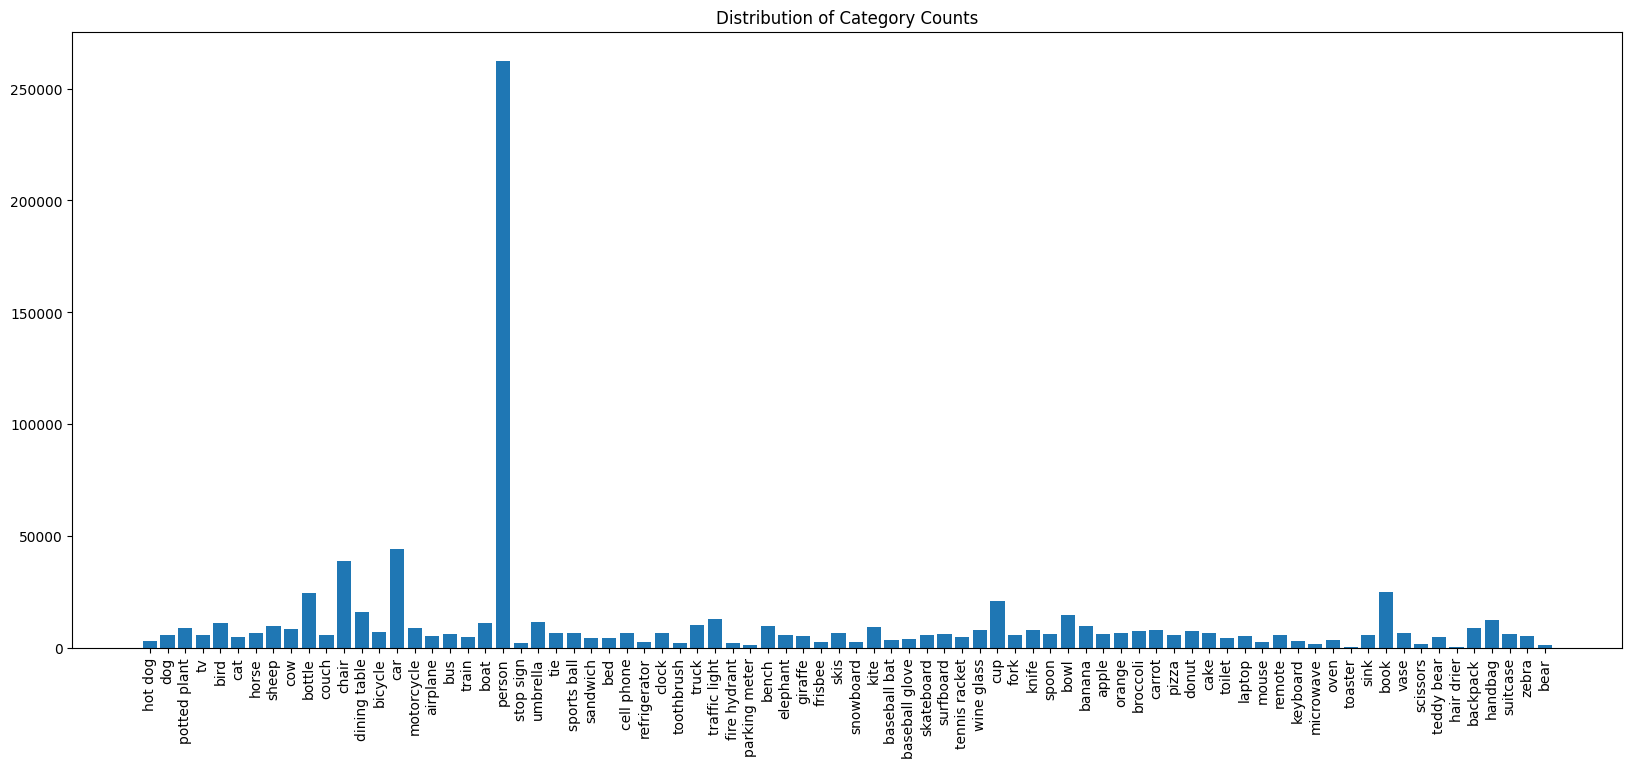

In [ ]:
id_to_name = {c["id"]: c["name"] for c in data["categories"]}

for cid, count in sorted(category_counts.items()):
    print(f"{cid} ({id_to_name[cid]}): {count} samples")

names = [id_to_name[cid] for cid in category_counts.keys()]
counts = [category_counts[cid] for cid in category_counts.keys()]

plt.figure(figsize=(20,8))
plt.bar(names, counts)
plt.xticks(rotation=90)
plt.title("Distribution of Category Counts")
plt.show()


In [ ]:
for i in range(3):
  print(train_pairs_detection[i])
  print(val_pairs_detection[i])

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}
{'img': './data/coco2017/images/val2017/val2017/000000289343.jpg', 'boxes': [[473.07, 395.93, 38.65, 28.67], [204.01, 235.08, 60.84, 177.36], [0.43, 499.79, 339.79, 106.45], [204.42, 304.1, 52.51, 152.76]], 'labels': [18, 1, 15, 2]}
{'img': './data/coco2017/images/train2017_subset/000000200365.jpg', 'boxes': [[234.22, 317.11, 149.39, 38.55], [239.48, 347.87, 160.0, 57.81], [296.65, 388.33, 1.03, 0.0], [251.87, 333.42, 125.94, 22.71], [128.24, 192.99, 511.76, 281.33], [0.0, 36.05, 562.4, 443.74], [131.1, 0.0, 508.9, 24

In [ ]:
# type
sample= train_pairs_detection[0]

print("img_path: ", type(sample))
# print("bbox: ", type(sample[1]), "len: ", len(sample[1]))
# print("category: ", type(sample[2]))

img_path:  <class 'dict'>


# Image Classification (object centric based)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
# from imblearn.over_sampling import SMOTE
from skimage.feature import local_binary_pattern

#### 1. crop area max & 1 label per bbox in 1 image

In [ ]:
def detection_to_classification_pairs(detection_pairs):
  cls_pairs=[]

  for item in detection_pairs:
    boxes=item['boxes']
    labels = item['labels']

    if len(boxes)==0:
      continue

    # hitung area bbox
    areas=[w*h for (_,_,w,h) in boxes]

    # get bbox terbesar
    max_idx = np.argmax(areas)
    main_label = labels[max_idx]

    cls_pairs.append({
        "img": item['img'],
        "bbox": boxes[max_idx],
        "label": main_label
    })

  return cls_pairs

In [ ]:
train_pairs_cls = detection_to_classification_pairs(train_pairs_detection)
val_pairs_cls = detection_to_classification_pairs(val_pairs_detection)

print(train_pairs_cls[0])
print("Train cls size: ", len(train_pairs_cls))

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'bbox': [346.58, 1.07, 292.01, 343.71], 'label': 1}
Train cls size:  7920


In [ ]:
SELECTED_CLASS=[1,2,3,18]
# person, bicycle, car, dog

def filter_class(pairs, allowed_class):
  return [p for p in pairs if p["label"] in allowed_class]

# train_pairs_cls = balance_data(train_pairs_cls, 1, 50000)
train_pairs_cls = filter_class(train_pairs_cls, SELECTED_CLASS)
val_pairs_cls   = filter_class(val_pairs_cls, SELECTED_CLASS)
print(len(train_pairs_cls))
print(len(val_pairs_cls))

1773
1785


In [ ]:
from collections import Counter
labels = [p["label"] for p in train_pairs_cls]

# Hitung distribusi
df = pd.DataFrame(train_pairs_cls)
counts = df['label'].value_counts().sort_index()

label_names = {1: "person", 2: "bicycle", 3: "car", 18: "dog"}
counts_df = counts.to_frame(name='Jumlah')
counts_df['Nama Kelas'] = counts_df.index.map(label_names)

print(counts_df)

       Jumlah Nama Kelas
label                   
1        1118     person
2         191    bicycle
3         383        car
18         81        dog


In [ ]:
# 2. encode label spy (0,1,2,3)

le = LabelEncoder()
train_labels = le.fit_transform([p["label"] for p in train_pairs_cls])
val_labels = le.transform([p["label"] for p in val_pairs_cls])

print(train_labels[:5])
print(val_labels)

[0 1 0 3 1]
[3 3 0 ... 0 0 0]


In [ ]:
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
le = joblib.load("label_encoder.pkl")

print("Urutan kelas di SVM Anda:")
for i, class_name in enumerate(le.classes_):
    print(f"Index {i} -> Label: {class_name}")

Urutan kelas di SVM Anda:
Index 0 -> Label: 1
Index 1 -> Label: 2
Index 2 -> Label: 3
Index 3 -> Label: 18


#### 2. Augmentation (imbalance class)

In [ ]:
import os

In [ ]:
ds_path= '/content/drive/MyDrive/KULIAH/SEM-5/obj_detection/filtered_images/filtered_images/train'

print(os.path.exists(ds_path))
print(os.listdir(ds_path))

True
['1', '2', '18', '3']


In [ ]:
import random

def balance_metadata(pairs, target_label=1):
  major_data=[p for p in pairs if p["label"]==target_label]
  minor_data=[p for p in pairs if p["label"]!=target_label]

  target_count = len(major_data)-200 # acuan=class person
  balanced_list = list(major_data)

  # brp byk tiap class minor hrs di duplicate
  uniq_minor_labels = set(p['label'] for p in minor_data)

  for lbl in uniq_minor_labels:
    specific_minor_data=[p for p in minor_data if p['label']==lbl]

    if len(specific_minor_data)==0:
      continue

    # duplicate minor hingga jml = mayor
    multiplication_factor = target_count//len(specific_minor_data)
    balanced_list.extend(specific_minor_data*multiplication_factor)

    # add sisanya acak (spy jml img sama)
    remainder = target_count % len(specific_minor_data)
    balanced_list.extend(random.sample(specific_minor_data, remainder))

  return balanced_list

train_pairs_balanced = balance_metadata(train_pairs_cls, target_label=1)
print(f"Total data after balancing oversample: {len(train_pairs_balanced)}")

Total data after balancing oversample: 3872


In [ ]:
# custom dataset with augmentation
train_paths = [
    os.path.join(ds_path, str(p['label']), os.path.basename(p['img']))
    for p in train_pairs_balanced
]
train_labels = [p['label'] for p in train_pairs_balanced]

def load_and_augment(image_path, label, bbox):
  # 1. read
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # img = tf.image.resize(img, [224, 224])

  img = tf.image.random_brightness(img, max_delta=0.1)
  # norm
  img = tf.cast(img, tf.float32) / 255.0

  return img, label, bbox

{'img': './data/coco2017/images/train2017_subset/000000334140.jpg', 'bbox': [69.21, 76.62, 555.03, 301.8], 'label': 2}
./data/coco2017/images/train2017_subset/000000143560.jpg


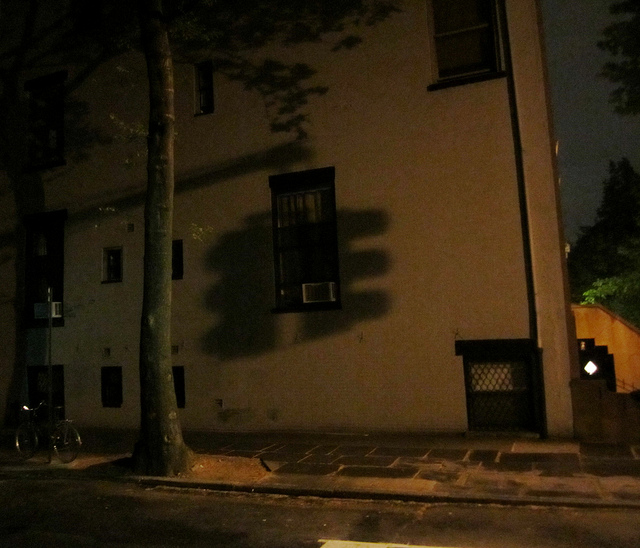

In [ ]:
# print(train_pairs_balanced[0][['img']])
print(train_pairs_balanced[2300])
path = train_pairs_balanced[2222]['img']
print(path)
image=cv2.imread(path)
cv2_imshow(image)

In [ ]:
# Buat dataset dari tensor slices
train_bboxes = [p['bbox'] for p in train_pairs_balanced]

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels, train_bboxes))

# loading & augmentasi
train_ds = train_ds.map(load_and_augment, num_parallel_calls=tf.data.AUTOTUNE)

# Batching dan Prefetching
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


##### EDA

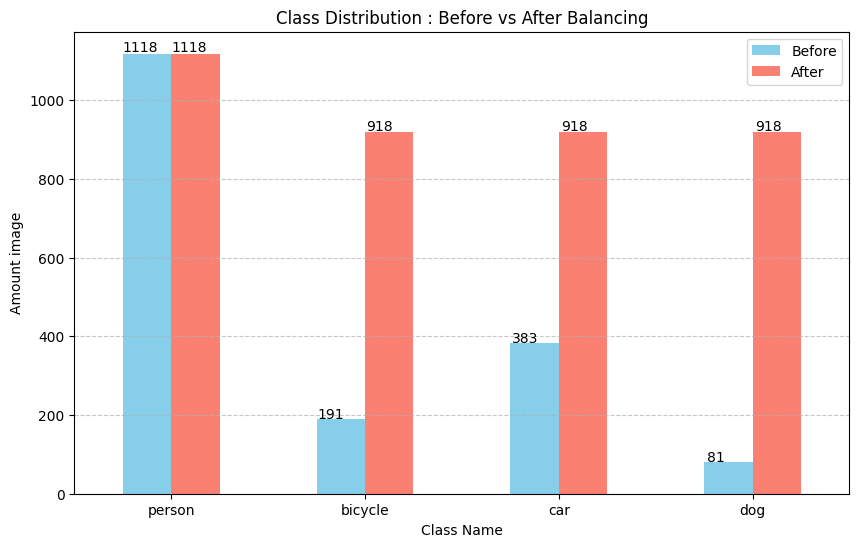

In [ ]:
# before augment
df_before = pd.DataFrame(train_pairs_cls)
counts_before = df_before['label'].value_counts().sort_index()

# after balanced & augmented
df_after = pd.DataFrame(train_pairs_balanced)
counts_after = df_after['label'].value_counts().sort_index()

label_names = {1: "person", 2: "bicycle", 3: "car", 18: "dog"}
eda_df = pd.DataFrame({
    'Before': counts_before,
    'After': counts_after
})
eda_df.index = eda_df.index.map(label_names)

# PLOTTING
ax = eda_df.plot(kind='bar', figsize=(10, 6), rot=0, color=['skyblue', 'salmon'])
plt.title('Class Distribution : Before vs After Balancing')
plt.xlabel('Class Name')
plt.ylabel('Amount image')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label angka di atas bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()



In [ ]:
eda_df = pd.DataFrame({
    'ID': counts_before.index,
    'Class': counts_before.index.map(label_names),
    'Before': counts_before.values,
    'After': counts_after.values
})

# --- FIX: Paksa kolom menjadi numeric untuk menghindari TypeError ---
eda_df['Before'] = pd.to_numeric(eda_df['Before'], errors='coerce').fillna(0)
eda_df['After'] = pd.to_numeric(eda_df['After'], errors='coerce').fillna(0)

# 3. Hitung persentase
total_Before = eda_df['Before'].sum()
total_After = eda_df['After'].sum()

# Gunakan f-string untuk formatting agar tidak mengganggu tipe data asli kolom
eda_df['% Before'] = eda_df['Before'].apply(lambda x: f"{(x/total_Before*100):.2f}%" if total_Before > 0 else "0%")
eda_df['% After'] = eda_df['After'].apply(lambda x: f"{(x/total_After*100):.2f}%" if total_After > 0 else "0%")

# 4. Print dengan format rapi
print("\nDistribution Tabel (Summary):")
print("==========================================================================")
print(eda_df.to_string(index=False))
print("==========================================================================")
print(f"Total Data Before: {int(total_Before)}")
print(f"Total Data After: {int(total_After)}")



Distribution Tabel (Summary):
 ID   Class  Before  After % Before % After
  1  person    1118   1118   63.06%  28.87%
  2 bicycle     191    918   10.77%  23.71%
  3     car     383    918   21.60%  23.71%
 18     dog      81    918    4.57%  23.71%
Total Data Before: 1773
Total Data After: 3872


#### 3. AFTER AUGMENT: Preprocessing & extract feature

In [ ]:
def apply_clahe(gray):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(gray)

In [ ]:
def crop_object(img_path, bbox):

  if isinstance(img_path, str):
    img = cv2.imread(img_path)
  else:
    img = img_path

  h_img, w_img = img.shape[:2]
  x,y,w,h = map(int, bbox) # Explicitly cast to int

  x=max(0,x)
  y=max(0,y)
  w=min(w, w_img-x)
  h=min(h, h_img-y)

  crop = img[y:y+h, x:x+w]
  return crop

# 1. crop & extract feature
def extract_hog_lbp_object_centric(img_path, bbox):
    crop= crop_object(img_path, bbox)
    crop = cv2.resize(crop, (224,224))
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray= apply_clahe(gray)


    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    )

    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")

    n_bins=int(lbp.max()+1)
    lbp_hist, _ = np.histogram(
        lbp,
        bins=n_bins,
        range=(0,n_bins),
        density=True
    )

    return np.concatenate([hog_feat, lbp_hist])

In [ ]:
# val
X_val   = [extract_hog_lbp_object_centric(p["img"], p["bbox"]) for p in val_pairs_cls]
y_val   = [p['label'] for p in val_pairs_cls]

In [ ]:
print(y_val)

[18, 18, 1, 18, 3, 1, 18, 3, 18, 1, 2, 18, 3, 18, 2, 1, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 3, 2, 2, 2, 3, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 3, 3, 2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 18, 18, 1, 18, 18, 1, 18, 18, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18, 3, 1, 18, 1, 18, 1, 1, 18, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 3, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
X_train = []
y_train = []

for img_tensor, label_tensor, bbox_tensor in tqdm(train_ds,
                                                  total=len(train_pairs_balanced),
                                                  desc="Ekstraksi Fitur Train"):
    # 1. preparing
    img_np = (img_tensor.numpy() * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    label = int(label_tensor.numpy())

    # 2. Crop dan Resize (Buat variabel crop_final)
    crop = crop_object(img_bgr, bbox_tensor.numpy())
    crop_final = cv2.resize(crop, (224, 224))

    # 3. AUGMENT
    if label != 1:  #(Bicycle, Car, Dog)
        # Random Flip
        if random.random() > 0.5:
            crop_final = cv2.flip(crop_final, 1) # Flip horizontal

    # 4. convert to gray & fitur
    gray = cv2.cvtColor(crop_final, cv2.COLOR_BGR2GRAY)
    gray = apply_clahe(gray)

    # Ekstraksi HOG & LBP
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm="L2-Hys")
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)

    features = np.concatenate([hog_feat, lbp_hist])

    X_train.append(features)
    y_train.append(label)


Ekstraksi Fitur Train: 100%|██████████| 3872/3872 [04:08<00:00, 15.60it/s]


In [ ]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

In [ ]:
print(y_train)

[          1           1           1 ...          18          18          18]


In [ ]:
print(len(X_train), X_train[0].shape)
# X_train = np.array(X_train, dtype=np.float32)

3872 (26254,)


In [ ]:
# normlaisasi
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
joblib.dump(scaler, 'scaler_augmd.pkl')

['scaler_augmd.pkl']

#### ver 1 : without PCA dimensional reduction (oversample 918)

In [ ]:
clf_918 = LinearSVC(C=1.0,
                max_iter=5000,
                class_weight='balanced')
clf_918.fit(X_train, y_train)

LinearSVC(class_weight='balanced', max_iter=5000)

In [ ]:
# with augment bright & random flip horizontal (dual=True)
val_preds = clf_918.predict(X_val)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))


              precision    recall  f1-score   support

      person       0.94      0.69      0.80      1589
     bicycle       0.16      0.62      0.25        37
         car       0.20      0.69      0.31       102
         dog       0.11      0.26      0.16        57

    accuracy                           0.67      1785
   macro avg       0.35      0.56      0.38      1785
weighted avg       0.86      0.67      0.74      1785



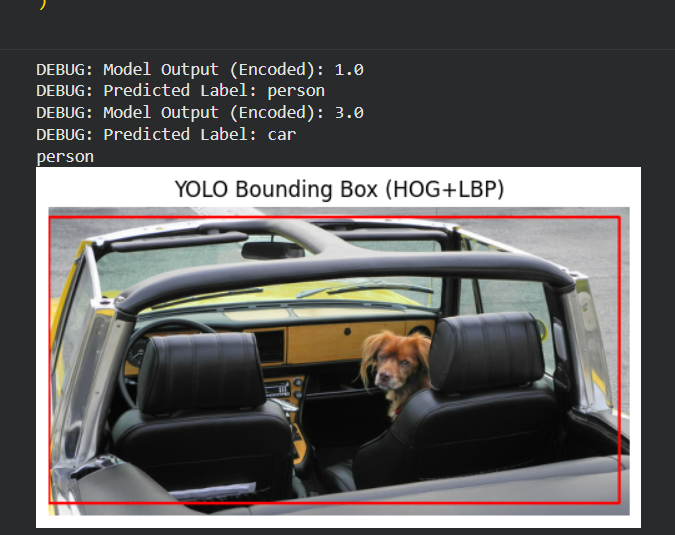

#### ver 2 : without PCA dimensional reduction (Balancing 718 for minor class)

In [ ]:
clf1 = LinearSVC(C=1.0,
                max_iter=5000,
                class_weight='balanced')
clf1.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced', max_iter=5000)

In [ ]:
# with augment bright & random flip horizontal (dual=True)
val_preds = clf1.predict(X_val)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))


              precision    recall  f1-score   support

      person       0.94      0.66      0.78      1589
     bicycle       0.12      0.65      0.21        37
         car       0.21      0.66      0.31       102
         dog       0.10      0.28      0.15        57

    accuracy                           0.65      1785
   macro avg       0.34      0.56      0.36      1785
weighted avg       0.86      0.65      0.72      1785



In [ ]:
# 4. train classifier
clf = LinearSVC(C=1.0,
                max_iter=5000,
                class_weight='balanced',
                dual=False)
clf.fit(X_train, y_train)

LinearSVC(class_weight='balanced', dual=False, max_iter=5000)

In [ ]:
# with augment bright & random flip horizontal on boxes
val_preds = clf.predict(X_val)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))


              precision    recall  f1-score   support

      person       0.94      0.71      0.81      1589
     bicycle       0.12      0.62      0.20        37
         car       0.23      0.68      0.35       102
         dog       0.11      0.19      0.14        57

    accuracy                           0.69      1785
   macro avg       0.35      0.55      0.37      1785
weighted avg       0.86      0.69      0.75      1785



In [ ]:
val_preds = clf.predict(X_val)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))
# without augmentation (just oversample)

              precision    recall  f1-score   support

      person       0.93      0.82      0.87      1589
     bicycle       0.21      0.51      0.30        37
         car       0.24      0.65      0.35       102
         dog       0.11      0.05      0.07        57

    accuracy                           0.78      1785
   macro avg       0.37      0.51      0.40      1785
weighted avg       0.85      0.78      0.81      1785



In [ ]:
val_preds = clf.predict(X_val)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))
# hog lbp (object centric with crop)
# brightness random full img

              precision    recall  f1-score   support

      person       0.94      0.62      0.75      1589
     bicycle       0.20      0.65      0.30        37
         car       0.18      0.68      0.28       102
         dog       0.09      0.35      0.14        57

    accuracy                           0.61      1785
   macro avg       0.35      0.57      0.37      1785
weighted avg       0.86      0.61      0.69      1785



In [ ]:
val_preds = clf.predict(X_val)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))
# hog lbp (object centric with crop)
### too many augment

              precision    recall  f1-score   support

      person       0.94      0.65      0.77      1589
     bicycle       0.11      0.62      0.18        37
         car       0.22      0.59      0.32       102
         dog       0.07      0.25      0.11        57

    accuracy                           0.63      1785
   macro avg       0.33      0.53      0.35      1785
weighted avg       0.86      0.63      0.71      1785



In [ ]:
le = LabelEncoder()
train_labels_encoded = le.fit_transform(y_train)

joblib.dump(le, 'label_encoder_aug.pkl')
print("LabelEncoder berhasil disimpan!")


LabelEncoder berhasil disimpan!


#### save model (non pca)

In [ ]:
import pickle

In [ ]:
filename_pkl = "svc_hoglbp_aug65.pkl"
with open(filename_pkl, 'wb') as file:
    pickle.dump(clf1, file)

print(f"Model berhasil disimpan sebagai {filename_pkl}")

Model berhasil disimpan sebagai svc_hoglbp_aug65.pkl


In [ ]:
import pickle
# save
filename_pkl = "svc_hoglbp_aug69.pkl"
with open(filename_pkl, 'wb') as file:
    pickle.dump(clf, file)

print(f"Model berhasil disimpan sebagai {filename_pkl}")



Model berhasil disimpan sebagai svc_hoglbp_aug69.pkl


#### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [ ]:
# PCA
clf_pca = LinearSVC(C=1.0,
                max_iter=5000,
                class_weight='balanced')
clf_pca.fit(X_train_pca, y_train)

LinearSVC(class_weight='balanced', max_iter=5000)

In [ ]:
val_preds = clf_pca.predict(X_val_pca)
print(classification_report(y_val, val_preds, target_names=['person', 'bicycle', 'car', 'dog']))
# hog lbp (object centric with crop)
###

              precision    recall  f1-score   support

      person       0.94      0.75      0.83      1589
     bicycle       0.17      0.51      0.26        37
         car       0.20      0.67      0.31       102
         dog       0.08      0.09      0.08        57

    accuracy                           0.72      1785
   macro avg       0.35      0.50      0.37      1785
weighted avg       0.85      0.72      0.77      1785



In [ ]:
print(X_train_pca[0].shape, len(X_train_pca))

(256,) 4472


In [ ]:
# save PCA
filename_pkl = "model_svc_hoglbp_pca.pkl"
with open(filename_pkl, 'wb') as file:
    pickle.dump(clf_pca, file)

print(f"Model berhasil disimpan sebagai {filename_pkl}")

In [ ]:
# download PCAnya
joblib.dump(pca, 'hoglbp_pca256.joblib')


## Inference

#### inference (Oversampling 718 with augment)

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
yolo=YOLO("yolov8n.pt") # nano utk bound box sj

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 2. GET bbox YOLO
def get_bboxes_from_yolo(img_path, conf_thresh=0.25):
  results= yolo(img_path, conf=conf_thresh, verbose=False)
  detections=[]

  for r in results:
    if r.boxes is None:
      continue

    for box in r.boxes:
      x1,y1,x2,y2 = box.xyxy[0].cpu().numpy()

      w=x2-x1
      h=y2-y1

      detections.append({
          "bbox": (int(x1), int(y1), int(w), int(h)),
          "conf": float(box.conf[0])
      })

  return detections

# get luas terbesar / conf tertinggi
def select_largest_bbox(detections):
  if len(detections)==0:
    return None

  areas = [d["bbox"][2] * d["bbox"][3] for d in detections] # w*h
  # areas=[w*h for(x,y,w,h) in [d['bbox'] for d in detections]]
  idx=np.argmax(areas) # max area
  return detections[idx]['bbox']

In [ ]:
# select best bounding box
def select_best_bbox(detections, allowed_class):
  candidates=[d for d in detections if d["label"] in allowed_class]
  if not candidates:
    return None
  # return max(candidates, key=lambda d: d['conf']*d['area'])
  return max(candidates, key=lambda d: d['conf'])

In [ ]:
def predict_image_yolo_bbox_revised(img_path, model, clf, scaler=None, label_map=None):
    # 1. Detection box dari YOLO (hanya bbox bkn label)
    all_detections = get_bboxes_from_yolo(img_path, conf_thresh=0.5)

    if not all_detections:
        return "no object detected"

    # 2. tiap deteksi label dari CLASSIFIER ekstrak MANUAL
    candidates_with_labels = []
    for d in all_detections:
        bbox = d["bbox"]
        conf = d["conf"]

        feat = extract_hog_lbp_object_centric(img_path, bbox)

        assert feat.shape[0] == scaler.n_features_in_

        feat = feat.reshape(1,-1)
        if scaler is not None:
            feat = scaler.transform(feat)

        # feat = pca.transform(feat)
        # model predict
        pred_index = clf.predict(feat)[0] # 0,1,2,3
        print(f"DEBUG: Model Output (Encoded): {pred_index}")
        predicted_label = label_map[pred_index] if label_map else pred_index
        print(f"DEBUG: Predicted Label: {predicted_label}")

        candidates_with_labels.append({
            "bbox": bbox,
            "conf": conf,
            "label": predicted_label,
            "area": d["bbox"][2] * d["bbox"][3] # Hitung area
        })

    # 3. Filter kandidat berdasarkan SELECTED_CLASS (dibatasi 4 class aj)
    filtered_candidates = [
        d for d in candidates_with_labels
        if d["label"] in SELECTED_CLASS
    ]

    if not filtered_candidates:
        return "no target object found"

    # 4. terbaik dari kandidat
    best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'])
    # best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'] * d['area'])
    return best_bbox_data['label']

In [ ]:
print(dict(zip(le.classes_, le.transform(le.classes_))))
#{1: 0, 2: 1, 3: 2, 18: 3}


{np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(18): np.int64(3)}


In [ ]:
def show_yolo_bbox(img_path, bbox, title="Detected Object"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x, y, w, h = bbox
    cv2.rectangle(
        img,
        (x, y),
        (x + w, y + h),
        (255, 0, 0),
        2
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 2.0
DEBUG: Predicted Label: bicycle
person


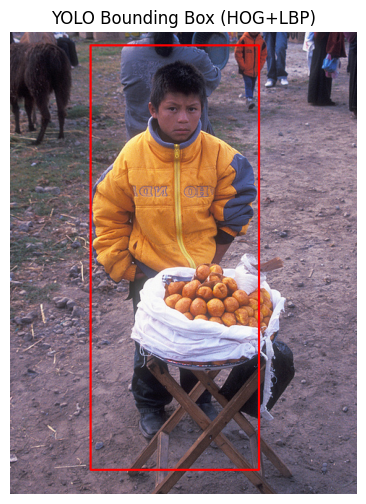

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[222]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf1,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 18.0
DEBUG: Predicted Label: dog
dog


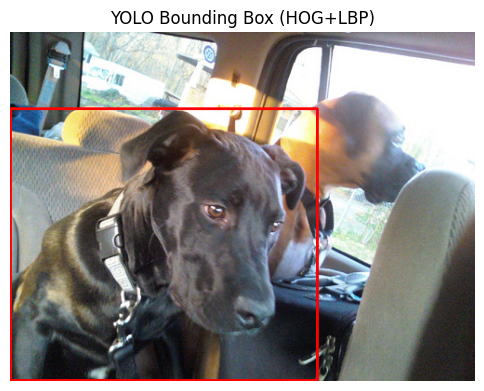

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[11]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf1,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 2.0
DEBUG: Predicted Label: bicycle
bicycle


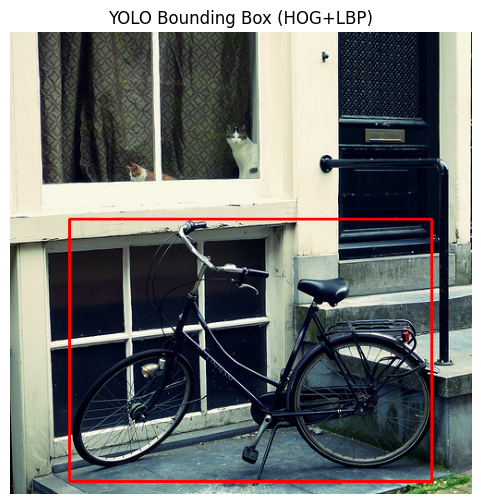

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[188]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf1,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 3.0
DEBUG: Predicted Label: car
person


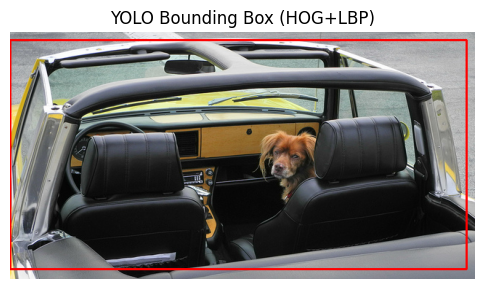

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[20]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf1,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


- path=train_pairs_cls[20]["img"] supposed to be "car" based on label, but predict as "person" in 718 augmentation oversampling minor class

#### Test inference (oversample 918)

DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 2.0
DEBUG: Predicted Label: bicycle
person


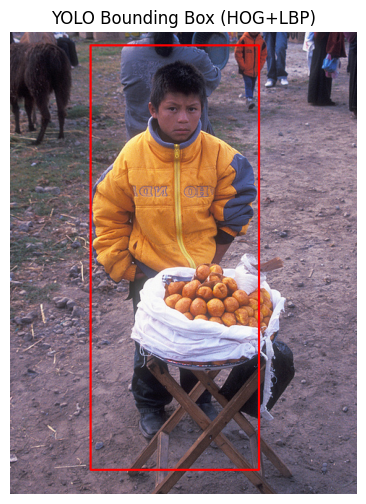

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[222]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf_918,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 18.0
DEBUG: Predicted Label: dog
dog


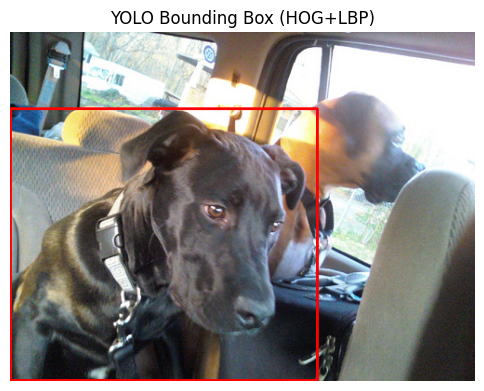

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[11]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf_918,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 2.0
DEBUG: Predicted Label: bicycle
bicycle


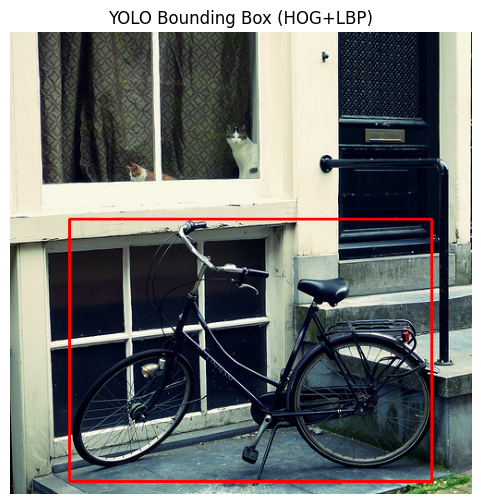

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[188]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf_918,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 3.0
DEBUG: Predicted Label: car
person


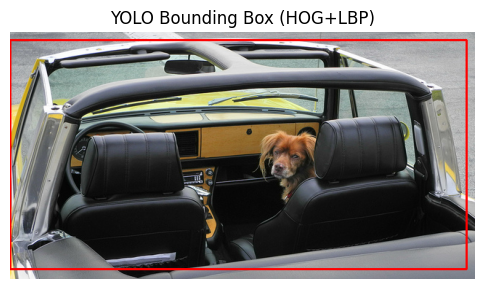

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[20]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf_918,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


- path=train_pairs_cls[20]["img"] supposed to be "car" based on label, but predict as "person" in 918 images after augmentation oversampling minor class

#### inference (Oversampling without augment)

In [ ]:
from ultralytics import YOLO
yolo=YOLO("yolov8n.pt") # nano utk bound box sj

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 2. GET bbox YOLO
def get_bboxes_from_yolo(img_path, conf_thresh=0.25):
  results= yolo(img_path, conf=conf_thresh, verbose=False)
  detections=[]

  for r in results:
    if r.boxes is None:
      continue

    for box in r.boxes:
      x1,y1,x2,y2 = box.xyxy[0].cpu().numpy()

      w=x2-x1
      h=y2-y1

      detections.append({
          "bbox": (int(x1), int(y1), int(w), int(h)),
          "conf": float(box.conf[0])
      })

  return detections

# get luas terbesar / conf tertinggi
def select_largest_bbox(detections):
  if len(detections)==0:
    return None

  areas = [d["bbox"][2] * d["bbox"][3] for d in detections] # w*h
  # areas=[w*h for(x,y,w,h) in [d['bbox'] for d in detections]]
  idx=np.argmax(areas) # max area
  return detections[idx]['bbox']

In [ ]:
# select best bounding box
def select_best_bbox(detections, allowed_class):
  candidates=[d for d in detections if d["label"] in allowed_class]
  if not candidates:
    return None
  # return max(candidates, key=lambda d: d['conf']*d['area'])
  return max(candidates, key=lambda d: d['conf'])

In [ ]:
def predict_image_yolo_bbox_revised(img_path, model, clf, scaler=None, label_map=None):
    # 1. Detection box dari YOLO (hanya bbox bkn label)
    all_detections = get_bboxes_from_yolo(img_path, conf_thresh=0.5)

    if not all_detections:
        return "no object detected"

    # 2. tiap deteksi label dari CLASSIFIER ekstrak MANUAL
    candidates_with_labels = []
    for d in all_detections:
        bbox = d["bbox"]
        conf = d["conf"]

        feat = extract_hog_lbp_object_centric(img_path, bbox)

        assert feat.shape[0] == scaler.n_features_in_

        feat = feat.reshape(1,-1)
        if scaler is not None:
            feat = scaler.transform(feat)

        # feat = pca.transform(feat)
        # model predict
        pred_index = clf.predict(feat)[0] # 0,1,2,3
        print(f"DEBUG: Model Output (Encoded): {pred_index}")
        predicted_label = label_map[pred_index] if label_map else pred_index
        print(f"DEBUG: Predicted Label: {predicted_label}")

        candidates_with_labels.append({
            "bbox": bbox,
            "conf": conf,
            "label": predicted_label,
            "area": d["bbox"][2] * d["bbox"][3] # Hitung area
        })

    # 3. Filter kandidat berdasarkan SELECTED_CLASS (dibatasi 4 class aj)
    filtered_candidates = [
        d for d in candidates_with_labels
        if d["label"] in SELECTED_CLASS
    ]

    if not filtered_candidates:
        return "no target object found"

    # 4. terbaik dari kandidat
    best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'])
    # best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'] * d['area'])
    return best_bbox_data['label']

In [ ]:
print(dict(zip(le.classes_, le.transform(le.classes_))))
#{1: 0, 2: 1, 3: 2, 18: 3}


{np.float32(1.0): np.int64(0), np.float32(2.0): np.int64(1), np.float32(3.0): np.int64(2), np.float32(18.0): np.int64(3)}


In [ ]:
def show_yolo_bbox(img_path, bbox, title="Detected Object"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x, y, w, h = bbox
    cv2.rectangle(
        img,
        (x, y),
        (x + w, y + h),
        (255, 0, 0),
        2
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 2.0
DEBUG: Predicted Label: bicycle
person


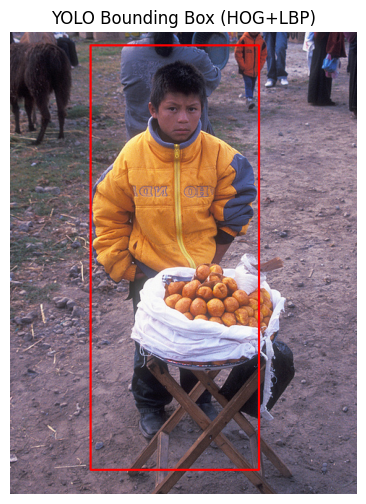

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[222]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 18.0
DEBUG: Predicted Label: dog
dog


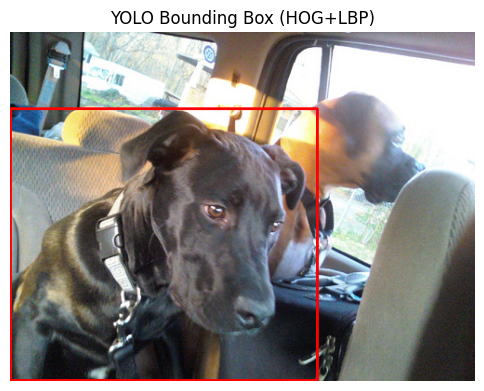

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[11]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 2.0
DEBUG: Predicted Label: bicycle
bicycle


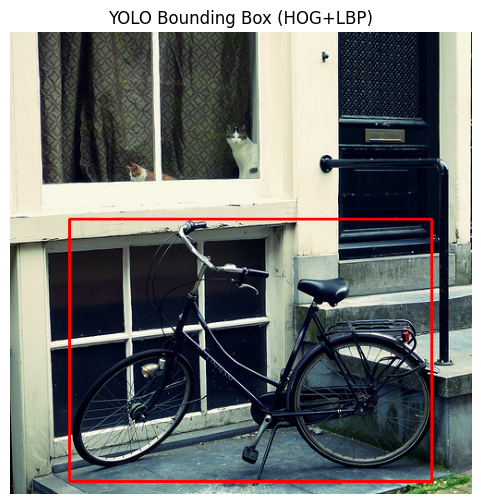

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[188]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
person


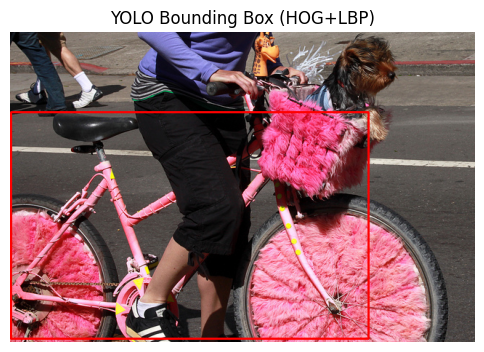

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[66]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


DEBUG: Model Output (Encoded): 1.0
DEBUG: Predicted Label: person
DEBUG: Model Output (Encoded): 3.0
DEBUG: Predicted Label: car
person


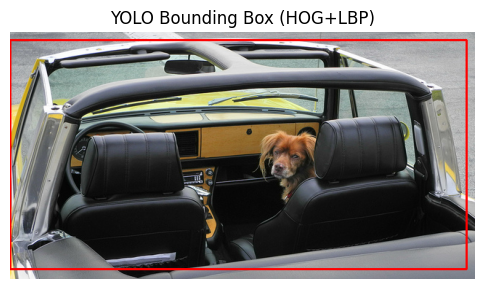

In [ ]:
label_map = {
    1: "person",         # Encoded 0 is COCO ID 1
    2: "bicycle",        # Encoded 1 is COCO ID 2
    3: "car",            # Encoded 2 is COCO ID 3
    18: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
path=train_pairs_cls[20]["img"]

pred_label=predict_image_yolo_bbox_revised(
    img_path=path,
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


## BEFORE AUGMENTATION version

#### 3. Preprocessing & extract feature

In [ ]:
def apply_clahe(gray):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(gray)

In [ ]:
def crop_object(img_path, bbox):
  img = cv2.imread(img_path)
  h_img, w_img = img.shape[:2]

  x,y,w,h = map(int, bbox) # Explicitly cast to int

  x=max(0,x)
  y=max(0,y)
  w=min(w, w_img-x)
  h=min(h, h_img-y)

  crop = img[y:y+h, x:x+w]
  return crop

# 1. crop & extract feature
def extract_hog_lbp_object_centric(img_path, bbox):
    crop= crop_object(img_path, bbox)
    crop = cv2.resize(crop, (224,224))
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray= apply_clahe(gray)


    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    )

    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")

    n_bins=int(lbp.max()+1)
    lbp_hist, _ = np.histogram(
        lbp,
        bins=n_bins,
        range=(0,n_bins),
        density=True
    )

    return np.concatenate([hog_feat, lbp_hist])

In [ ]:
X_train = [extract_hog_lbp_object_centric(p["img"], p["bbox"]) for p in train_pairs_cls]
X_val   = [extract_hog_lbp_object_centric(p["img"], p["bbox"]) for p in val_pairs_cls]

In [ ]:
print(len(X_train), X_train[0].shape)
# X_train = np.array(X_train, dtype=np.float32)

1773 (26254,)


In [ ]:
# normlaisasi
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
joblib.dump(scaler, 'scaler74.pkl')

['scaler74.pkl']

#### random undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, train_labels_res = rus.fit_resample(X_train, train_labels)
print(f"Jumlah sampel setelah Undersampling: {len(train_labels_res)}")
# Jumlah sampel sekarang akan jauh lebih kecil daripada 4472

clf_rus = LinearSVC(C=1.0, max_iter=3000)
clf_rus.fit(X_train_res, train_labels_res) # under sampling


Jumlah sampel setelah Undersampling: 324


LinearSVC(max_iter=3000)

In [ ]:
val_preds = clf_rus.predict(X_val)
print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))
# hog lbp (object centric with crop)
### SMOTE X_train_resample, train_labels_resample (di UNDERSAMPLING)

              precision    recall  f1-score   support

           1       0.97      0.37      0.53      1589
           2       0.08      0.59      0.14        37
           3       0.22      0.60      0.32       102
          18       0.07      0.79      0.13        57

    accuracy                           0.40      1785
   macro avg       0.33      0.59      0.28      1785
weighted avg       0.88      0.40      0.50      1785



#### without PCA dimensional reduction

In [ ]:
# 4. train classifier
clf = LinearSVC(C=1.0,
                max_iter=5000,
                class_weight='balanced')
clf.fit(X_train, train_labels)

LinearSVC(class_weight='balanced', max_iter=5000)

In [ ]:
val_preds = clf.predict(X_val)
print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))
# hog lbp (object centric with crop)
###

              precision    recall  f1-score   support

           1       0.94      0.60      0.73      1589
           2       0.08      0.62      0.14        37
           3       0.20      0.65      0.30       102
          18       0.11      0.30      0.16        57

    accuracy                           0.59      1785
   macro avg       0.33      0.54      0.33      1785
weighted avg       0.86      0.59      0.68      1785



#### PCA


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [ ]:
# PCA
clf_pca = LinearSVC(C=1.0,
                max_iter=3000,
                class_weight='balanced')
clf_pca.fit(X_train_pca, train_labels)

LinearSVC(class_weight='balanced', max_iter=3000)

In [ ]:
val_preds = clf_pca.predict(X_val_pca)
print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))
# hog lbp (object centric with crop)
###

              precision    recall  f1-score   support

           1       0.94      0.78      0.85      1589
           2       0.16      0.51      0.24        37
           3       0.24      0.63      0.35       102
          18       0.11      0.16      0.13        57

    accuracy                           0.74      1785
   macro avg       0.36      0.52      0.39      1785
weighted avg       0.86      0.74      0.79      1785



In [ ]:
print(X_train_pca[0].shape, len(X_train_pca))

(256,) 1773


In [ ]:
# save PCA 74%
filename_pkl = "model_svc_hoglbp_pca74.pkl"
with open(filename_pkl, 'wb') as file:
    pickle.dump(clf_pca, file)

print(f"Model berhasil disimpan sebagai {filename_pkl}")

Model berhasil disimpan sebagai model_svc_hoglbp_pca74.pkl


In [ ]:
# download PCA
joblib.dump(pca, 'hoglbp_pca256.joblib')


['hoglbp_pca256.joblib']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### save model

In [ ]:
import pickle

In [ ]:
# save
filename_pkl = "svc_single59.pkl"
with open(filename_pkl, 'wb') as file:
    pickle.dump(clf, file)

print(f"Model berhasil disimpan sebagai {filename_pkl}")



Model berhasil disimpan sebagai svc_single59.pkl


In [ ]:
val_preds = clf.predict(X_val)
print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))

# hog lbp (object centric no crop)

              precision    recall  f1-score   support

           1       0.94      0.60      0.73      1589
           2       0.08      0.62      0.14        37
           3       0.20      0.65      0.30       102
          18       0.11      0.30      0.16        57

    accuracy                           0.59      1785
   macro avg       0.33      0.54      0.33      1785
weighted avg       0.86      0.59      0.68      1785



In [ ]:
# # 5. eval
# # balanced class & standardize (only hog)
# val_preds = clf.predict(X_val)
# print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))

#### predict image

In [ ]:
def predict_image(img_path, bbox, model, scaler=None, label_map=None):
  feat = extract_hog_lbp_object_centric(img_path, bbox)
  feat = feat.reshape(1, -1)

  if scaler is not None:
      feat = scaler.transform(feat)

  encoded_pred_label = model.predict(feat)[0]

  if label_map is not None:
      # Inverse transform the encoded label to get the original COCO ID
      original_coco_id = le.inverse_transform([encoded_pred_label])[0]
      return label_map[original_coco_id]

  return encoded_pred_label

./data/coco2017/images/train2017_subset/000000270744.jpg


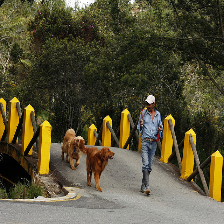

In [ ]:
img_path = train_pairs_cls[55]['img']

print(img_path)

img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))
cv2_imshow(img)

In [ ]:
label_map = {
    1: "person",
    2: "bicycle",
    3: "car",
    18: "dog",
   }

pred = predict_image(
    train_pairs_cls[55]['img'],
    train_pairs_cls[55]['bbox'], # Pass the bounding box
    clf,
    scaler=scaler,
    label_map=label_map
)

print("Predicted class:", pred)

Predicted class: person



#### Inference

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
yolo=YOLO("yolov8n.pt") # nano utk bound box sj

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 2. GET bbox YOLO
def get_bboxes_from_yolo(img_path, conf_thresh=0.25):
  results= yolo(img_path, conf=conf_thresh, verbose=False)
  detections=[]

  for r in results:
    if r.boxes is None:
      continue

    for box in r.boxes:
      x1,y1,x2,y2 = box.xyxy[0].cpu().numpy()

      w=x2-x1
      h=y2-y1

      detections.append({
          "bbox": (int(x1), int(y1), int(w), int(h)),
          "conf": float(box.conf[0])
      })

  return detections

# get luas terbesar / conf tertinggi
def select_largest_bbox(detections):
  if len(detections)==0:
    return None

  areas = [d["bbox"][2] * d["bbox"][3] for d in detections] # w*h
  # areas=[w*h for(x,y,w,h) in [d['bbox'] for d in detections]]
  idx=np.argmax(areas)
  return detections[idx]['bbox']

In [ ]:
# select best bounding box
def select_best_bbox(detections, allowed_class):
  candidates=[d for d in detections if d["label"] in allowed_class]
  if not candidates:
    return None
  # return max(candidates, key=lambda d: d['conf']*d['area'])
  return max(candidates, key=lambda d: d['conf'])

In [ ]:
# def predict_image_yolo_bbox(img_path, model, scaler=None, label_map=None):
#   detections= get_bboxes_from_yolo(img_path)
#   # bbox = select_largest_bbox(detections)
#   bbox = select_best_bbox(detections, SELECTED_CLASS)

#   if bbox is None:
#     return "no object detected"

#   feat = extract_hog_lbp_object_centric(img_path, bbox)
#   assert feat.shape[0] == scaler.n_features_in_
#   feat = feat.reshape(1,-1)
#   if scaler is not None:
#     feat = scaler.transform(feat)

#   pred = model.predict(feat)[0]
#   if label_map:
#     return label_map[pred]

#   return pred

In [ ]:
def predict_image_yolo_bbox_revised(img_path, model, clf, scaler=None, label_map=None):
    # 1. Detection box dari YOLO (hanya bbox bkn label)
    all_detections = get_bboxes_from_yolo(img_path, conf_thresh=0.5)

    if not all_detections:
        return "no object detected"

    # 2. tiap deteksi label dari CLASSIFIER ekstrak MANUAL
    candidates_with_labels = []
    for d in all_detections:
        bbox = d["bbox"]
        conf = d["conf"]

        feat = extract_hog_lbp_object_centric(img_path, bbox)

        assert feat.shape[0] == scaler.n_features_in_
        feat = feat.reshape(1,-1)
        if scaler is not None:
            feat = scaler.transform(feat)

        feat = pca.transform(feat)
        # model predict
        pred_index = clf.predict(feat)[0]
        predicted_label = label_map[pred_index] if label_map else pred_index

        candidates_with_labels.append({
            "bbox": bbox,
            "conf": conf,
            "label": predicted_label,
            "area": d["bbox"][2] * d["bbox"][3] # Hitung area
        })

    # 3. Filter kandidat berdasarkan SELECTED_CLASS (dibatasi 4 class aj)
    filtered_candidates = [
        d for d in candidates_with_labels
        if d["label"] in SELECTED_CLASS
    ]

    if not filtered_candidates:
        return "no target object found"

    # 4. terbaik dari kandidat
    best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'])
    # best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'] * d['area'])
    return best_bbox_data['label']

In [ ]:
def show_yolo_bbox(img_path, bbox, title="Detected Object"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x, y, w, h = bbox
    cv2.rectangle(
        img,
        (x, y),
        (x + w, y + h),
        (255, 0, 0),
        2
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


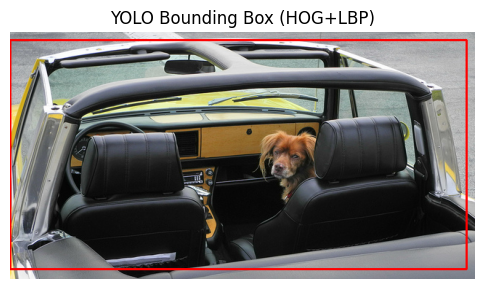

In [ ]:
path=train_pairs_cls[20]["img"]
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box (HOG+LBP)"
)


#### PCA ver (without oversampling & augmentation)

In [ ]:
label_map = {
    0: "person",         # Encoded 0 is COCO ID 1
    1: "bicycle",        # Encoded 1 is COCO ID 2
    2: "car",            # Encoded 2 is COCO ID 3
    3: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
pred_label=predict_image_yolo_bbox_revised(
    img_path=train_pairs_cls[20]['img'],
    model=yolo,
    clf=clf_pca,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)

person


#### non PCA (without oversampling & augmentation)

In [ ]:
def predict_image_yolo_bbox_noPCA(img_path, model, clf, scaler=None, label_map=None):
    # 1. Dapatkan SEMUA deteksi dari YOLO (hanya bbox dan conf, belum ada label)
    all_detections = get_bboxes_from_yolo(img_path, conf_thresh=0.5) # Naikkan conf thresh yolo untuk hasil awal yg lebih bersih

    if not all_detections:
        return "no object detected"

    # 2. Iterasi melalui setiap deteksi dan dapatkan label dari CLASSIFIER MANUAL Anda
    candidates_with_labels = []
    for d in all_detections:
        bbox = d["bbox"]
        conf = d["conf"]

        # Ekstrak fitur manual Anda (HOG/LBP/SIFT/etc) dari area bbox ini
        feat = extract_hog_lbp_object_centric(img_path, bbox)

        # Pastikan shape benar untuk scaler/model
        assert feat.shape[0] == scaler.n_features_in_
        feat = feat.reshape(1,-1)

        if scaler is not None:
            feat = scaler.transform(feat)

        # feat = pca.transform(feat)
        # Dapatkan prediksi dari MODEL MANUAL ANDA (clf)
        pred_index = clf.predict(feat)[0]
        predicted_label = label_map[pred_index] if label_map else pred_index

        # Tambahkan label prediksi ini ke kandidat
        candidates_with_labels.append({
            "bbox": bbox,
            "conf": conf,
            "label": predicted_label,
            "area": d["bbox"][2] * d["bbox"][3] # Hitung area
        })

    # 3. Filter kandidat berdasarkan SELECTED_CLASS yang Anda inginkan (misalnya, hanya 'person')
    # Di sinilah SELECTED_CLASS Anda digunakan
    filtered_candidates = [
        d for d in candidates_with_labels
        if d["label"] in SELECTED_CLASS # SELECTED_CLASS harus didefinisikan sebelumnya
    ]

    if not filtered_candidates:
        return "no target object found"

    # 4. Pilih yang terbaik dari kandidat yang difilter
    best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'] * d['area'])

    # Kembalikan hanya label prediksi terbaik
    return best_bbox_data['label']

In [ ]:
label_map = {
    0: "person",         # Encoded 0 is COCO ID 1
    1: "bicycle",        # Encoded 1 is COCO ID 2
    2: "car",            # Encoded 2 is COCO ID 3
    3: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
pred_label=predict_image_yolo_bbox_noPCA(
    img_path=train_pairs_cls[20]['img'],
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)

car


- path=train_pairs_cls[20]["img"] supposed to be "car" based on label, and model with 0.59 accuracy but stable recall per class category success predict as "car"